# Time-Series Forecasting – Stock Prices

Here is Github Link for the project - https://github.com/rashedulemon/TSF_Stock_Prices

## Fetch Dataset from Yahoo Finance 

In [1]:
import datetime
import yfinance as yf
start_date = datetime.datetime(2020, 10, 1)
end_date = datetime.datetime(2025, 9, 1)
meta = yf.Ticker("AAPL")
data = meta.history(start=start_date, end=end_date)

## Export data to CSV file

In [2]:
data.to_csv("../data/AAPL_stock_data.csv")
print("Data exported to ../data/AAPL_stock_data.csv")
print(f"File saved with {len(data)} rows and {len(data.columns)} columns")

Data exported to ../data/AAPL_stock_data.csv
File saved with 1234 rows and 7 columns


## Importing libreries 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Data Preprocessing

In [4]:
df = pd.read_csv("../data/AAPL_stock_data.csv") #load dataset
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-10-01 00:00:00-04:00,114.430546,114.508365,112.669928,113.603737,116120400,0.0,0.0
1,2020-10-02 00:00:00-04:00,109.810126,112.222470,109.158407,109.936577,144712000,0.0,0.0
2,2020-10-05 00:00:00-04:00,110.802282,113.467526,110.452103,113.321617,106243800,0.0,0.0
3,2020-10-06 00:00:00-04:00,112.543427,112.951974,109.187554,110.072731,161498200,0.0,0.0
4,2020-10-07 00:00:00-04:00,111.492889,112.397517,111.016252,111.940338,96849000,0.0,0.0


In [5]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1) #drop unnecessary column
# Convert to datetime and then extract just the date part
df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.strftime('%Y-%m-%d') #convert date data to date time format so we can train model on time series
df.head()

,Date,Open,High,Low,Close,Volume
0,2020-10-01,114.430546,114.508365,112.669928,113.603737,116120400
1,2020-10-02,109.810126,112.222470,109.158407,109.936577,144712000
2,2020-10-05,110.802282,113.467526,110.452103,113.321617,106243800
3,2020-10-06,112.543427,112.951974,109.187554,110.072731,161498200
4,2020-10-07,111.492889,112.397517,111.016252,111.940338,96849000


In [6]:
df.set_index('Date',inplace=True) #set date as index

In [7]:
df.info() #see if there are any missing value

<class 'pandas.core.frame.DataFrame'>
Index: 1234 entries, 2020-10-01 to 2025-08-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1234 non-null   float64
 1   High    1234 non-null   float64
 2   Low     1234 non-null   float64
 3   Close   1234 non-null   float64
 4   Volume  1234 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 57.8+ KB


There is no missing value.

## Visualize the trends 

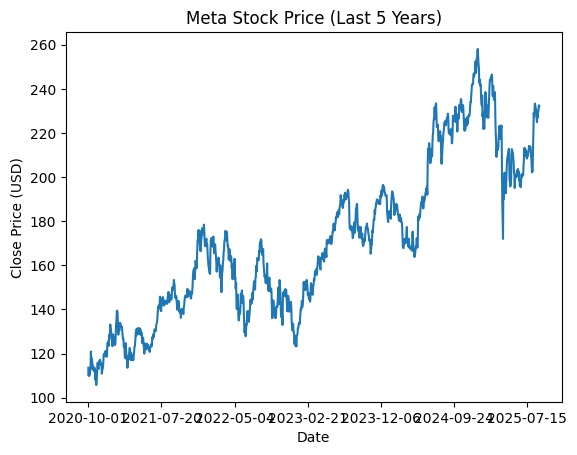

In [8]:
df['Close'].plot(title="Meta Stock Price (Last 5 Years)")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.show()

Plot above shows that the price of the stock increases over time. 

## Model Implementation

### Traditional statistical model ARIMA

To apply the ARIMA model we have to check the data is stationary or not.

In [9]:
from statsmodels.tsa.stattools import adfuller

values = df['Close'].values
result = adfuller(values) #applying adfuller to determin the dataset is stationary or not

print('Augmneted Dickey_fuller Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print('critical values at different levels:') #see critical values
for k, v in result[4].items():
    print('\t%s: %.3f' % (k, v))

Augmneted Dickey_fuller Statistic: -1.428010
p-value: 0.568777
critical values at different levels:
	1%: -3.436
	5%: -2.864
	10%: -2.568




Result: The data is NOT stationary

p-value (0.568777) > 0.05: We fail to reject the null hypothesis of non-stationarity
ADF statistic (-1.428) is greater than critical values, indicating non-stationarity
This is expected for stock prices, which typically show trends and don't revert to a constant mean


In [10]:
df['Close_diff'] = df['Close'] - df['Close'].shift(1) #finding dfference to make it stationary 
df['Close'].shift(1)

Date
2020-10-01           NaN
2020-10-02    113.603737
2020-10-05    109.936577
2020-10-06    113.321617
2020-10-07    110.072731
                 ...    
2025-08-25    227.759995
2025-08-26    227.160004
2025-08-27    229.309998
2025-08-28    230.490005
2025-08-29    232.559998
Name: Close, Length: 1234, dtype: float64

In [11]:
values = df['Close_diff'].dropna().values
result1 = adfuller(values)

print('Augmented Dickey-Fuller Statistic: %f' % result1[0])
print('p-value: %f' % result1[1])

print('critical values at different levels:')
for k, v in result1[4].items():
    print('\t%s: %.3f' % (k, v))

Augmented Dickey-Fuller Statistic: -20.701985
p-value: 0.000000
critical values at different levels:
	1%: -3.436
	5%: -2.864
	10%: -2.568


<Axes: xlabel='Date'>

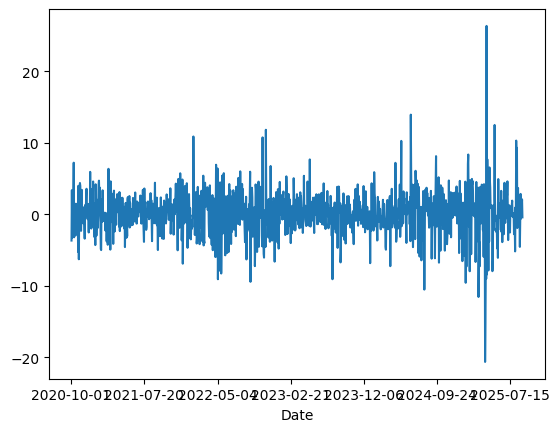

In [12]:
# let's plot to see the difference
df['Close_diff'].plot()

see the autocorellation and corelation

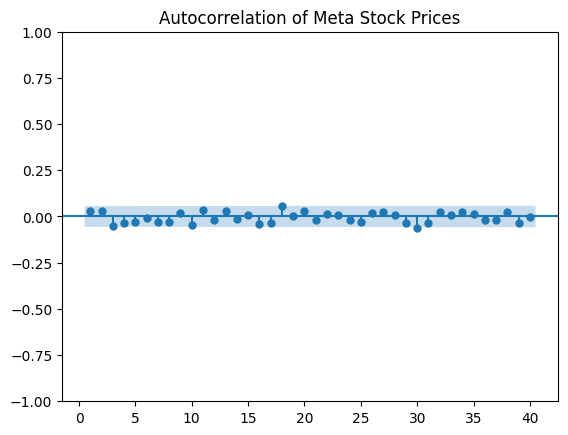

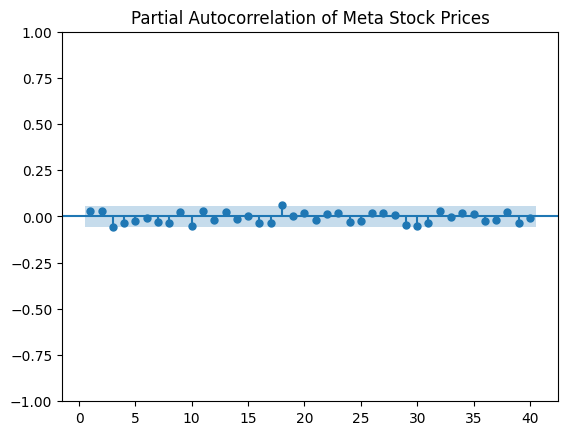

In [13]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plot_acf(df['Close_diff'].iloc[13:],lags=40
               ,title="Autocorrelation of Meta Stock Prices"
               ,zero=False
               )
fig = plot_pacf(df['Close_diff'].iloc[13:],lags=40
                ,title="Partial Autocorrelation of Meta Stock Prices"
                ,zero=False
                )

train arima model

In [14]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(df['Close'],order=(1,1,1)) #setup model using p=1 q=1 r=1
model_fit=model.fit()

c:\Users\emonr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\emonr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\emonr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [15]:
model_fit.summary() #train model

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1234
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3119.755
Date:                Fri, 03 Oct 2025   AIC                           6245.510
Time:                        01:36:30   BIC                           6260.862
Sample:                             0   HQIC                          6251.285
                               - 1234                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2278      0.594      0.383      0.701      -0.937       1.392
ma.L1         -0.1983      0.599     -0.331      0.740      -1.372       0.975
sigma2         9.2309      0.189     48.862      0.000       8.861       9.601
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              3176.29
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
print(len(df)) 

1234


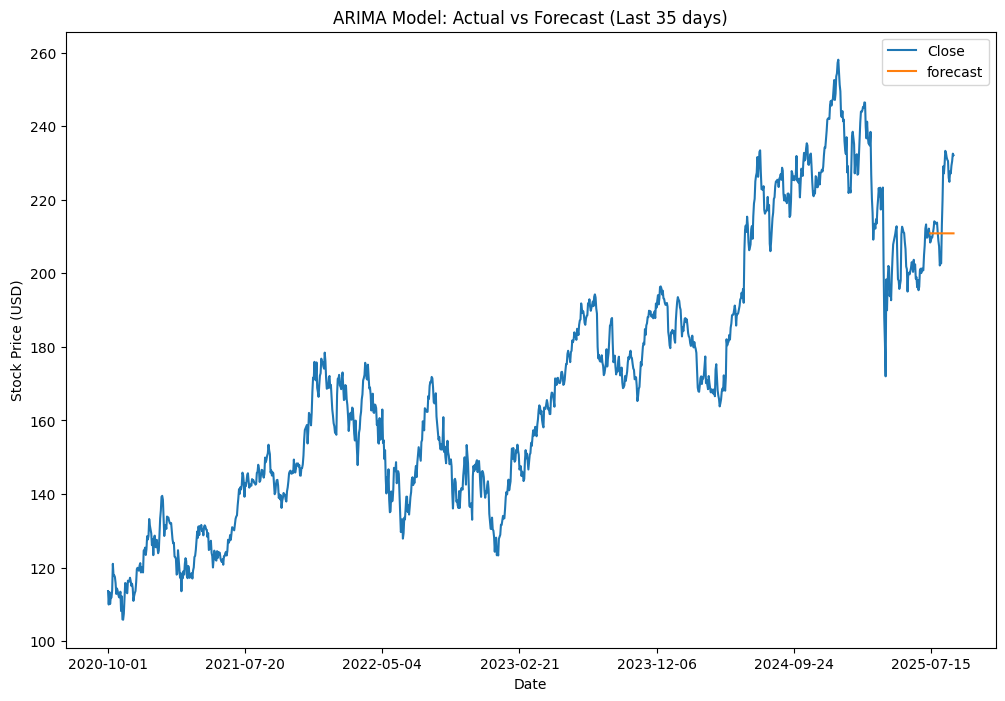

In [17]:
predictions = model_fit.predict(start=len(df)-35, end=len(df)-1, dynamic=True)

df['forecast'] = np.nan #add a column with nul values

df.iloc[-35:, df.columns.get_loc('forecast')] = predictions.values #append prediction values to the null values set before

df[['Close','forecast']].plot(figsize=(12,8))
plt.title('ARIMA Model: Actual vs Forecast (Last 35 days)')
plt.ylabel('Stock Price (USD)')
plt.show()


It seems not good let's try another way

In [18]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['Close'],order=(1, 1, 1),seasonal_order=(1,1,1,30)) #arima is low accurecy so sarimax is bing the use
results=model.fit()

c:\Users\emonr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\emonr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [19]:
predictions = results.predict(start=len(df)-35, end=len(df)-1, dynamic=True)

df['forecast'] = np.nan #add a column with nul values

df.iloc[-35:, df.columns.get_loc('forecast')] = predictions.values

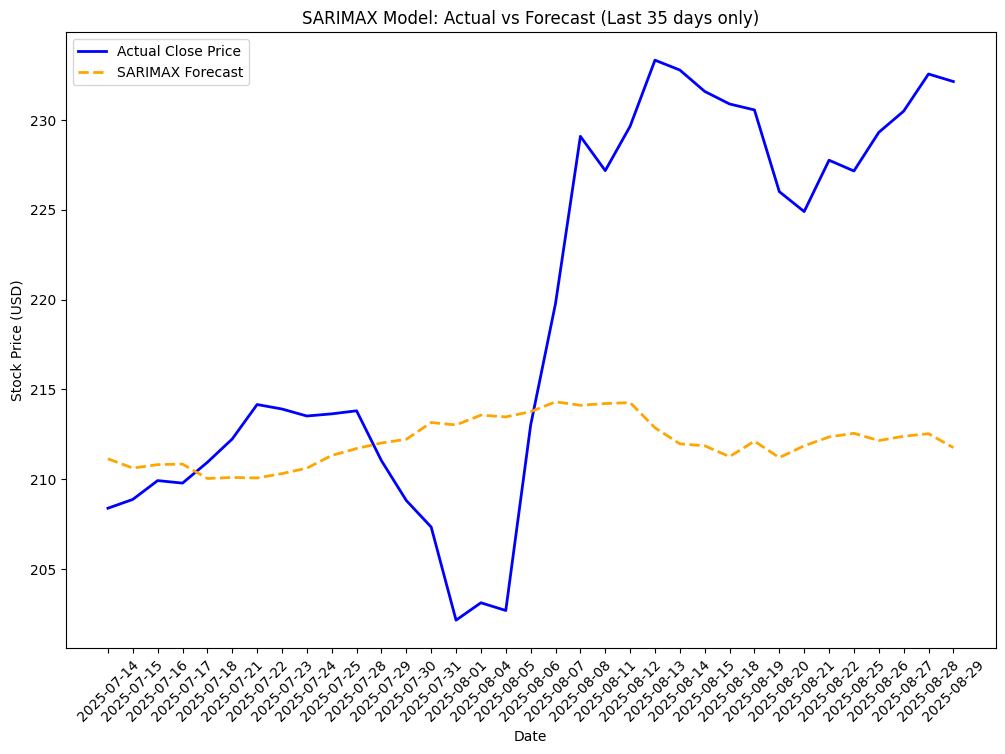

In [20]:
plt.figure(figsize=(12,8))

last_35_days = df[['Close', 'forecast']].iloc[-35:]

plt.plot(last_35_days.index, last_35_days['Close'], 
         label='Actual Close Price', color='blue', linewidth=2)

forecast_data = last_35_days['forecast'].dropna()
plt.plot(forecast_data.index, forecast_data.values, 
         label='SARIMAX Forecast', color='orange', linewidth=2, linestyle='--')

plt.title('SARIMAX Model: Actual vs Forecast (Last 35 days only)')
plt.ylabel('Stock Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.xticks(rotation=45)
plt.show()

from upper obserbation this can be improve by incresing seasonal ordrer

Calculate accuracy of the model

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error 
y_test = df['Close'].iloc[-35:].values
y_pred = df['forecast'].iloc[-35:].values

def calculate_metrics(y_true, y_pred): #a function which determine accurecy metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return rmse, mape

rmse, mape = calculate_metrics(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Percentage Error: {mape*100:.2f}%")

Root Mean Squared Error: 12.38
Mean Absolute Percentage Error: 4.43%


### Implement one machine learning or deep learning model

For time series data prophet is a better approach. It is very easy to implement.

In [22]:
df1 = pd.read_csv("../data/AAPL_stock_data.csv")
df1['Date'] = pd.to_datetime(df1['Date'], utc=True).dt.tz_localize(None)

df1.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-10-01 04:00:00,114.430546,114.508365,112.669928,113.603737,116120400,0.0,0.0
1,2020-10-02 04:00:00,109.810126,112.222470,109.158407,109.936577,144712000,0.0,0.0
2,2020-10-05 04:00:00,110.802282,113.467526,110.452103,113.321617,106243800,0.0,0.0
3,2020-10-06 04:00:00,112.543427,112.951974,109.187554,110.072731,161498200,0.0,0.0
4,2020-10-07 04:00:00,111.492889,112.397517,111.016252,111.940338,96849000,0.0,0.0


Train the model and show plot.

01:46:31 - cmdstanpy - INFO - Chain [1] start processing
01:46:31 - cmdstanpy - INFO - Chain [1] done processing


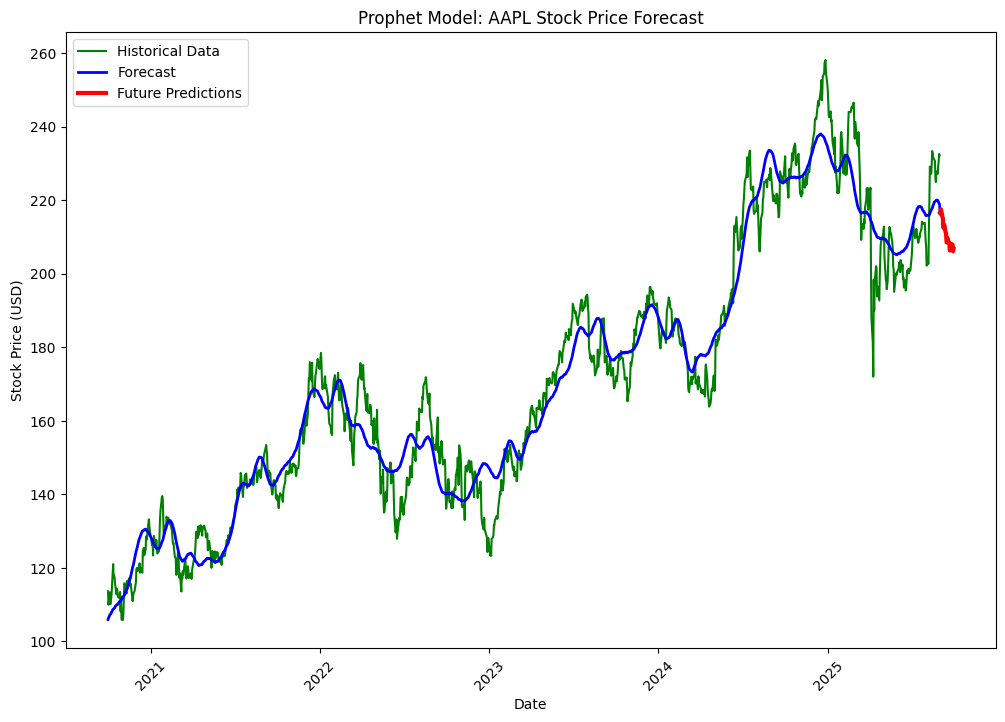

In [30]:
from prophet import Prophet

df_prophet = df1[['Date', 'Close']].copy()

df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Close': 'y'})
modelf = Prophet()
modelf.fit(df_prophet) #train phophet model

future = modelf.make_future_dataframe(periods=30) 
forecast = modelf.predict(future) #forcast using phophet model


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(df_prophet['ds'], df_prophet['y'], 'g-', markersize=3, label='Historical Data')

ax.plot(forecast['ds'], forecast['yhat'], 'b-', linewidth=2, label='Forecast')

future_start = len(df_prophet)
future_forecast = forecast.iloc[future_start:]
ax.plot(future_forecast['ds'], future_forecast['yhat'], 'r-', linewidth=3, label='Future Predictions') #mark forcasted data in red line

plt.title('Prophet Model: AAPL Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Print forecast values

In [24]:
print(future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

                      ds        yhat  yhat_lower  yhat_upper
1234 2025-08-30 04:00:00  216.455824  206.651032  225.712921
1235 2025-08-31 04:00:00  216.558528  206.636834  226.353073
1236 2025-09-01 04:00:00  217.469093  207.682404  226.753788
1237 2025-09-02 04:00:00  216.801338  206.976185  226.812605
1238 2025-09-03 04:00:00  216.121681  206.431681  226.113709
1239 2025-09-04 04:00:00  215.505489  205.890713  225.405771
1240 2025-09-05 04:00:00  215.031251  204.975719  225.018654
1241 2025-09-06 04:00:00  212.511025  202.591156  222.829814
1242 2025-09-07 04:00:00  212.455272  203.103142  222.798940
1243 2025-09-08 04:00:00  213.258142  203.516521  223.350291
1244 2025-09-09 04:00:00  212.534052  202.552618  221.310200
1245 2025-09-10 04:00:00  211.849006  201.949479  221.301467
1246 2025-09-11 04:00:00  211.276987  201.791684  221.304275
1247 2025-09-12 04:00:00  210.894190  201.472920  220.764505
1248 2025-09-13 04:00:00  208.509551  198.445880  217.317327
1249 2025-09-14 04:00:00

In [31]:
# accuracy of prophet
y_test = df_prophet['y'].iloc[-35:].values

y_pred = forecast['yhat'].iloc[-35:].values
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Percentage Error: {mape*100:.2f}%")

Root Mean Squared Error: 15.75
Mean Absolute Percentage Error: 5.97%


### Deep learning model - LSTM


- Layers 3
- Epoch 50
- Optimizer Adam


In [32]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

scaler = MinMaxScaler() # Normalize data
df['Scaled_Close'] = scaler.fit_transform(df[['Close']])


def create_dataset(data, look_back=60): # Create windowed datasets
    x, y = [], []
    for i in range(look_back, len(data)):
        x.append(data[i-look_back:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

look_back = 60
data = np.array(df['Scaled_Close']).reshape(-1, 1)
x, y = create_dataset(data, look_back)

split = int(0.8 * len(x)) #split data for train and test
x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# build and train LSTM model
# model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
#     tf.keras.layers.LSTM(50),
#     tf.keras.layers.Dense(1)
# ])


model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1),
])


model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/50


c:\Users\emonr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0239 - val_loss: 0.0244
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0060 - val_loss: 0.0064
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0041 - val_loss: 0.0088
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0039 - val_loss: 0.0065
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0032 - val_loss: 0.0041
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0035 - val_loss: 0.0077
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0032 - val_loss: 0.0038
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0030 - val_loss: 0.0060
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0029 - val_l

Export the model for HuggingFace

In [34]:
# Save the trained LSTM model
model.save("../model/lstm_stock_model.h5")

Predict and inverse-transform the values

In [36]:

y_pred = model.predict(x_test)
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [37]:
import numpy as np
print(" y pred and y test") #prediction and test values side by side
combined = np.column_stack((y_pred_rescaled,y_test_rescaled))
print(combined)



 y pred and y test
[[222.62345886 225.42088318]
 [224.65461731 226.31671143]
 [226.03479004 225.32133484]
 [226.49681091 226.46601868]
 [226.46853638 226.73475647]
 [226.25334167 231.92063904]
 [226.90982056 225.16209412]
 [226.9306488  225.72946167]
 [226.46862793 224.62458801]
 [225.65083313 225.74935913]
 [225.02099609 220.66304016]
 [223.86503601 224.72413635]
 [223.237854   228.47666931]
 [223.86114502 227.97897339]
 [225.15873718 226.49589539]
 [226.26824951 230.22851562]
 [227.56184387 232.76670837]
 [229.19584656 230.70628357]
 [230.35229492 231.0745697 ]
 [230.92828369 233.91136169]
 [231.51647949 235.38450623]
 [232.32745361 234.76737976]
 [233.01873779 229.69100952]
 [232.54840088 229.50189209]
 [231.33796692 230.3380127 ]
 [230.16151428 232.31877136]
 [229.72503662 232.58752441]
 [229.98843384 229.03407288]
 [230.00654602 224.86346436]
 [229.04110718 221.87738037]
 [227.10154724 220.98155212]
 [224.84741211 222.41487122]
 [223.20292664 221.68826294]
 [222.27116394 226.42620

Accuracy test

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)


print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Percentage Error: {mape*100:.2f}%")


Root Mean Squared Error: 6.63
Mean Absolute Percentage Error: 2.16%


Plot actual and predicted values

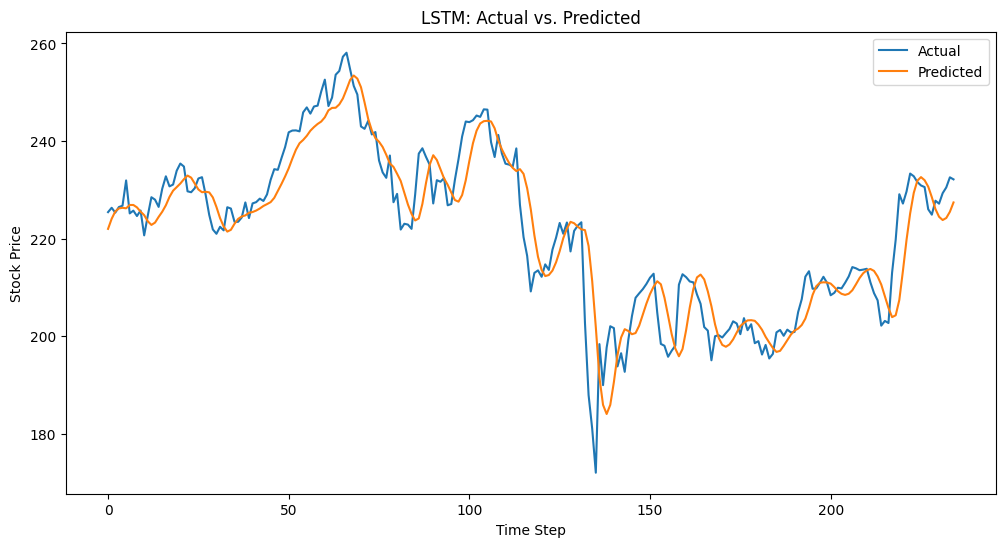

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.title('LSTM: Actual vs. Predicted')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


### Use rolling window evaluation to measure forecast accuracy 

In [ ]:

window_size = 50  # Number of time steps in each window
errors = []

test_start_idx = len(x_train)
test_data_scaled = data[test_start_idx:]  # scaled data for test period

# Create rolling windows from test data
for start in range(0, len(x_test) - 10): 
    test_input = x_test[start:start+1]  # Single test sample for rolling prediction
    actual_value = y_test[start]  # Actual value
    
    pred_scaled = model.predict(test_input, verbose=0)
    
    # inverse transform to original scale
    pred_original = scaler.inverse_transform(pred_scaled.reshape(-1, 1))
    actual_original = scaler.inverse_transform(actual_value.reshape(-1, 1))
    
    # error calculation
    error = abs(pred_original[0][0] - actual_original[0][0])
    errors.append(error)

# metrics
rmse = np.sqrt(np.mean(np.square(errors)))
mape = np.mean(np.abs(np.array(errors) / np.array([scaler.inverse_transform(y_test[i].reshape(-1, 1))[0][0] for i in range(len(errors))]))) * 100

print(f"Rolling Window Evaluation Results:")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Number of predictions evaluated: {len(errors)}")

Rolling Window Evaluation Results:
RMSE: 6.84
MAPE: 2.23%
Number of predictions evaluated: 225


# Compare the performance of different approaches.

ARIMA has fast training and prediction with well-stablisd statistical foundation. In this dataset it perform not good compare to other approach. ARIMA not good for complex pattern. To improve some SARIMAX which called seasonal arima applied which slightly better then ARIMA but not top notch. 
Machine Learning Approach - Prophet doing good at this point. It handles non-linear trends better than ARIMA. Very easy to implement also almost immune to missing data or outliner. The best approach was Deep Learning - LSTM it manage to do **RMSE: 6.99, MAPE: 2.35%** score which is pretty good.
After observing the notebook did a comparison plot of those model for better understanding.

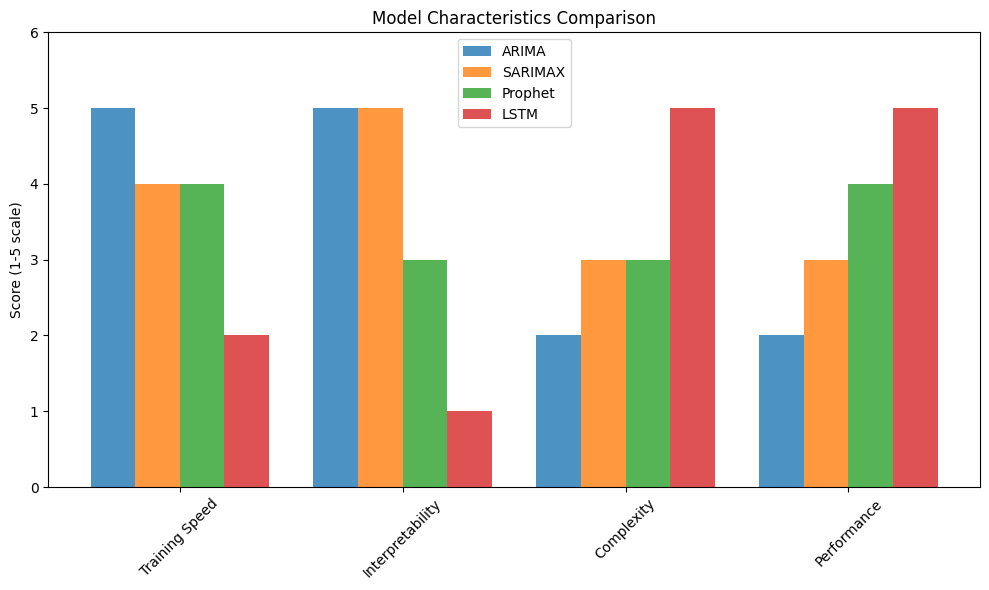

In [ ]:
characteristics = ['Training Speed', 'Interpretability', 'Complexity', 'Performance']
arima_scores = [5, 5, 2, 2]  # High speed, high interpret, low complex, poor perf
sarimax_scores = [4, 5, 3, 3]  # Good speed, high interpret, mod complex, mod perf
prophet_scores = [4, 3, 3, 4]  # Good speed, mod interpret, mod complex, good perf
lstm_scores = [2, 1, 5, 5]  # Slow, low interpret, high complex, excellent perf

x_char = np.arange(len(characteristics))
width_char = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x_char - 1.5*width_char, arima_scores, width_char, label='ARIMA', alpha=0.8)
plt.bar(x_char - 0.5*width_char, sarimax_scores, width_char, label='SARIMAX', alpha=0.8)
plt.bar(x_char + 0.5*width_char, prophet_scores, width_char, label='Prophet', alpha=0.8)
plt.bar(x_char + 1.5*width_char, lstm_scores, width_char, label='LSTM', alpha=0.8)

plt.ylabel('Score (1-5 scale)')
plt.title('Model Characteristics Comparison')
plt.xticks(x_char, characteristics, rotation=45)
plt.legend()
plt.ylim(0, 6)
plt.tight_layout()
plt.show()

### Table of all model accuracy

In [ ]:
# Table of all model accuracy
performance_data = {
    "Model": [],
    "RMSE": [],
    "MAPE": []
}
performance_data["Model"].extend(['SARIMAX (1,1,1)(1,1,1,30)', 'Prophet', 'LSTM (Test)', 'LSTM (Rolling)'])
performance_data["RMSE"].extend([12.38, 15.78, 6.99, 10.05])
performance_data["MAPE"].extend([4.43, 5.97, 2.35, 3.64])
comparison_df = pd.DataFrame(performance_data)
print("\n=== MODEL ACCURACY SUMMARY ===\n") 
print(comparison_df.to_string(index=False))



=== MODEL ACCURACY SUMMARY ===

                    Model  RMSE  MAPE
SARIMAX (1,1,1)(1,1,1,30) 12.38  4.43
                  Prophet 15.78  5.97
              LSTM (Test)  6.99  2.35
           LSTM (Rolling) 10.05  3.64
